# Tokenizer

Separating input to words or sub words

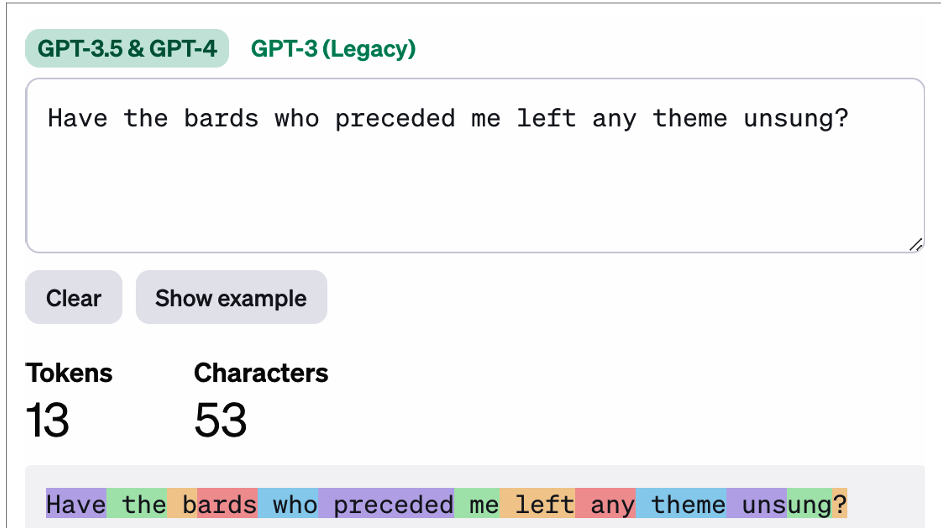

In [2]:
from transformers import AutoTokenizer

In [3]:
# tokenizer model
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

# prompt
prompt = "Write a message to stafin asking for help in a subject."

# text to unique token ids
text_2_tokens = tokenizer(prompt, return_tensors="pt").to("cuda")

The tokenizer will generate unique ID for a specific token in the tokenizer table.

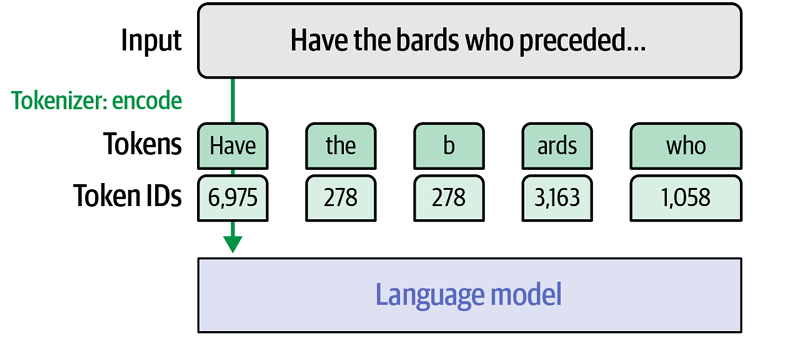

In [20]:
# tokenized text
for idx in text_2_tokens["input_ids"][0]:
    print(tokenizer.decode(idx))

Write
a
message
to
st
af
in
asking
for
help
in
a
subject
.


The output generated by the generator model will also be indices. these indices are again decoded to produce the output text.

Therefore, tokeninizer is required to,
1. Split input text in to words/parts of words.
2. Translate token ID of generated model output to actual text.

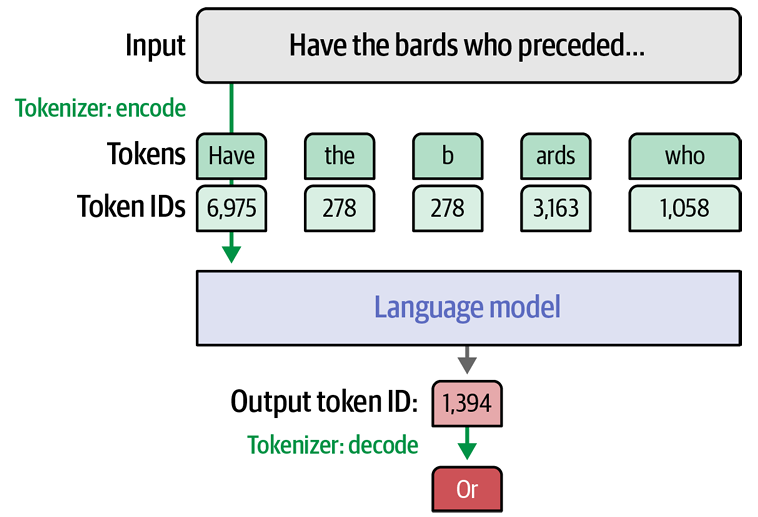

# Levels of token
1. Word level
   * unable to process new words not present in vocabulary
   * vocabulary size should be very large. eg: suffixes will be of separate token - apology, apologise, apologist
3. subword level
   * Most commnly used method
   * Able to break down new words to smaller character tokens that is part of the vocabulary
5. character level
   * Will require to model the information for combining or spelling out a word.
   * Context length in transformer model is limited due to individual letter taking separate token. Usually three times lesser length than subword level tokenizer
7. byte tokens
   * upcoming method.
   * Some subword methods use this to give tokens to words/characters that are unknown them.

# How does the tokenizer break down text?

The three factors that govern the tokenizer break down are:
* Tokenizer method - context they focus on. eg: text data, code data etc.
* parameters - vocabulary size, special tokens etc.
* training dataset - english tokenizer trained on japanese text produce bad results as their punctuations, spacings etc. vary

# Some Tokenization methods:
## 1. Byte Pair Encoding (BPE):
* Gives each character a unique byte value
* Joins freuqnectly co-occuring characters to a new unique byte value
* Final size = initial vocabulary size + number of merge operations

## 2. Starcoder2:
* BPE with few modifications to make it suitable for coding.

## 3. Galactica:
* More focued on scientific knowledge and is trained on many scientific papers and materials.

## 4. wordpiece:
* merges using a score rather than most frequent pair,
  * $score = \frac{frequency\ of\ pair}{freq\ of\ first\ element \times \ freq\ of\ second\ element}$
* joins by longest subword in vocabulry and not by pairs as in BPE.
  * eg: hugs: in BPE - {hu, gs}, hugs in WP - {hug, s}
 
## 5. Unigram:
* Done after performing an initial tokenization like BPE to reduce the vocabulary size by removing less probable tokens.
* Assuming unigram(probability of a word given another word = word), compute the probability of all combination of pre-tokens for a word and tokenize the one with highest probability.
* Compute a loss for the tokens.
* Try removing tokens and remove the token premanently which least increase the loss.

# Tokenization steps:

## 1. Normalisation:
used to remove accents, unnecessary white spaces, capitalisation (if required).

In [41]:
# BERT uncased tokenizer removes only accents and casing
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

print(tokenizer.backend_tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

hello how are u?


## 2. Pre-tokenization
The tokenizer doesn't perform on raw text, instaed it operates on subtext. Usually these subtexts or pre-tokens are separated by spaces and punctuations.

In [42]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('how', (7, 10)),
 ('are', (11, 14)),
 ('you', (16, 19)),
 ('?', (19, 20))]

In [44]:
# for different tokenizer, spaces are secured for use in decoding (reversible)
tokenizer = AutoTokenizer.from_pretrained("t5-small")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?") # doesn't split based on punctuations

[('▁Hello,', (0, 6)),
 ('▁how', (7, 10)),
 ('▁are', (11, 14)),
 ('▁you?', (16, 20))]

## 3.  Subsequent steps vary for each method

# BPE encoding implementation

In [53]:
corpus = [
    "This is the Hugging Face Course. This is for you",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",]

In [49]:
# normaliser and pretokenizer model
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [50]:
from collections import defaultdict

In [138]:
# word frequency in corpus
word_freq = defaultdict(int)

for text in corpus:

    # pretokenized
    pretokenized = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)

    # all words
    words = [word for word, offset in pretokenized]

    for word in words:
        
        word_freq[word] += 1

In [140]:
# vocabulary
vocab = set()

for word in word_freq.keys():
    for letter in word:
        vocab.add(letter)

vocab = sorted(list(vocab))

In [141]:
# split pretokens to characters
splits = {word: [c for c in word] for word in word_freq.keys()}

In [143]:
# training

# frequency of each pair
def comp_pair_freq(splits):

    pair_freq = defaultdict(int)

    for word, freq in word_freq.items():

        # get subword in a word
        split = splits[word]

        if len(split) == 1: # if subword = word
            continue

        for i in range(len(split) - 1):
            
            pair = (split[i], split[i+1])
            pair_freq[pair] += freq

    return pair_freq

In [144]:
# frequency of each pair
pair_freqs = comp_pair_freq(splits)

# highest frequency pair
best_pair = ""

# maximum frequnecy
max_freq = None

for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

best_pair, max_freq

(('i', 's'), 7)

In [145]:
# merge the best pair
def merge_pair(a, b, splits):

    for word in word_freq:
        
        split = splits[word]
        
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:

            if split[i] == a and split[i+1] == b:

                # add merge to each split
                split = split[:i] + [a+b] + split[i+2:]

            else:
                i += 1
        
        splits[word] = split

    return splits

In [148]:
splits = merge_pair(best_pair[0], best_pair[1], splits)

In [149]:
# now we have everything. Just do the looping

# vocab size
vocab_size = 50

merges = {}

while len(vocab)  < vocab_size:

    pair_freqs = comp_pair_freq(splits)

    best_pair = ""
    max_freq = None

    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq

    splits = merge_pair(*best_pair, splits)

    merges[best_pair] = best_pair[0] + best_pair[1]

    vocab.append(best_pair[0] + best_pair[1])

In [157]:
# tokenize new text

def tokenize(text):

    # pretokenize
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
 
    splits = [[l for l in word] for word in pre_tokenized_text]

    for pair, merge in merges.items():

        for idx, split in enumerate(splits):
    
            i = 0
            while i < len(split) - 1:
                # merge each pair
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split

    # return unqiue value
    return sum(splits, [])

In [158]:
tokenize("This is not a token.")

['Th', 'i', 's', 'Ġ', 'i', 's', 'Ġ', 'n', 'o', 't', 'Ġa', 'Ġtoken', '.']

# Token Embedding
Now that we have represented language as a sequecne of tokens, we need to convert it into numerical representation for computers to understand.

A embedding vector is given to each token in the tokenizer vcocabulary. A pretrained language model (randomly initialised like parameters initially) holds this embedding matrix along with the parameters.

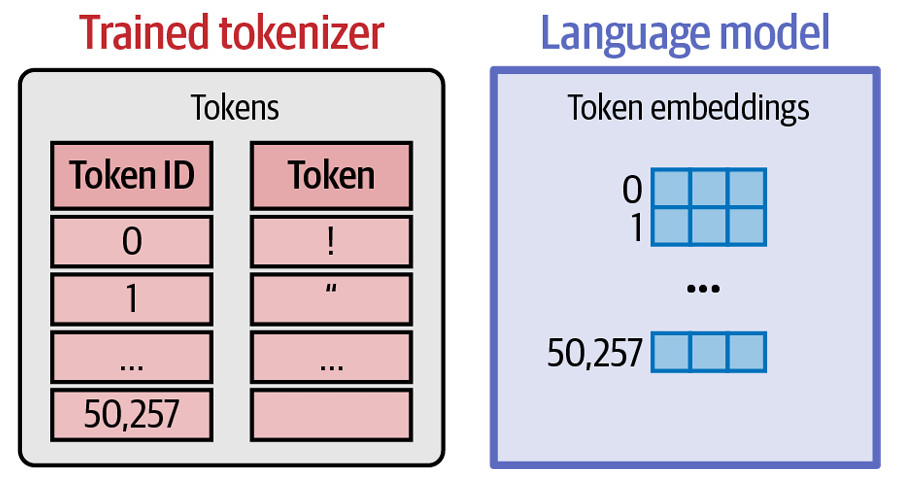

In [161]:
from transformers import AutoModel

In [163]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

# load a language model
model = AutoModel.from_pretrained("microsoft/deberta-v3-xsmall")

In [169]:
# tokenise the input
tokens = tokenizer("hello world. How are you?", return_tensors="pt")

# embedding - encoder in this case
output = model(**tokens)[0]

In [171]:
# Batch X N_tokens X embed_dim
output.shape

torch.Size([1, 9, 384])

In [172]:
output

tensor([[[-3.4638, -0.0706, -0.0813,  ..., -0.2409, -0.3318, -0.3218],
         [-0.3358,  0.3157,  0.4457,  ..., -0.5885, -0.2884, -0.6475],
         [-0.4851,  0.7477, -0.4272,  ...,  0.1906,  0.3551, -0.1260],
         ...,
         [-1.3192,  0.1839, -0.0181,  ...,  0.3866, -0.0640,  0.2384],
         [-1.2865, -0.2803, -0.2117,  ...,  0.2382,  0.4270, -0.4374],
         [-3.3362,  0.0060,  0.0951,  ..., -0.3407, -0.3365, -0.3048]]],
       grad_fn=<NativeLayerNormBackward0>)

This is the raw output of the language model. The other applications are built on top of this output.

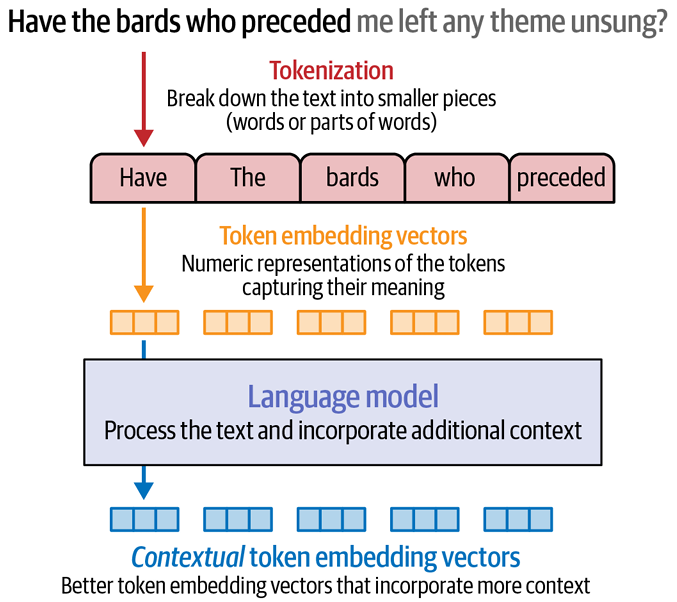

# 1. word2vec embedding

Two parts:
* skip-gram - take nearby words to center word
* negative sampling - Add few random tokens to get negative samples to avoid overfitting

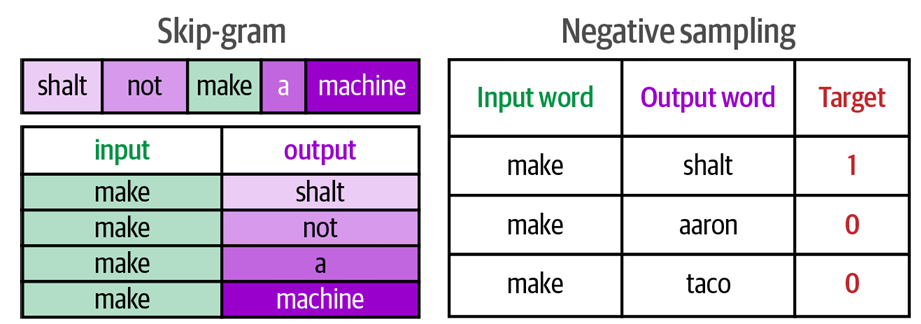

Using the above two methods, compute the nearness between center word and the nearby context words (1 for near and 0 for not near). Optimise the embedding vector.

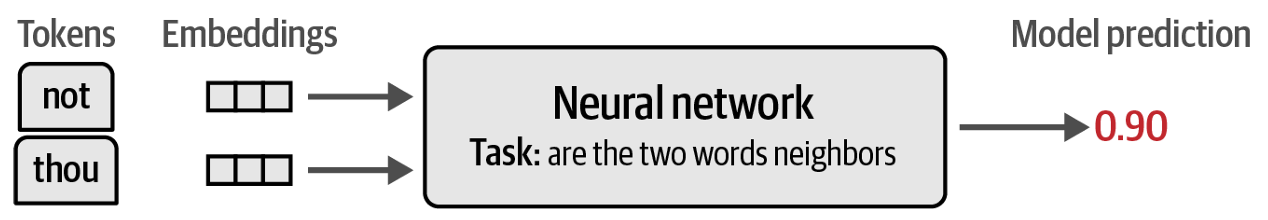

In [174]:
from gensim.models import Word2Vec
import pandas as pd
from urllib import request

In [177]:
# Get the playlist dataset file
data = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/train.txt')
# Parse the playlist dataset file. Skip the first two lines as
# they only contain metadata
lines = data.read().decode("utf-8").split('\n')[2:]
# Remove playlists with only one song
playlists = [s.rstrip().split() for s in lines if len(s.split()) > 1]
# Load song metadata
songs_file = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/song_hash.txt')
songs_file = songs_file.read().decode("utf-8").split('\n')
songs = [s.rstrip().split('\t') for s in songs_file]
songs_df = pd.DataFrame(data=songs, columns = ['id', 'title', 'artist'])
songs_df = songs_df.set_index('id')

In [188]:
# model training
model = Word2Vec(playlists, vector_size=32, window=10, negative=50, 
                 min_count=1, # ignores tokens with nearby freuqency less than 1 
                 workers=4)

In [199]:
# nearby embedding vectors
model.wv.most_similar(positive=str(18459))

[('12569', 0.9989145994186401),
 ('57826', 0.9988861083984375),
 ('984', 0.9988316893577576),
 ('58670', 0.9988097548484802),
 ('27105', 0.9988061785697937),
 ('27745', 0.998799204826355),
 ('32758', 0.9987978935241699),
 ('20649', 0.9987950921058655),
 ('6767', 0.9987939596176147),
 ('31485', 0.9987867474555969)]

In [201]:
songs_df.iloc[[18459, 984]]

,title,artist
id,,
18459,Caught Up,Usher
984,Addiction (w\/ Cassie),Ryan Leslie
